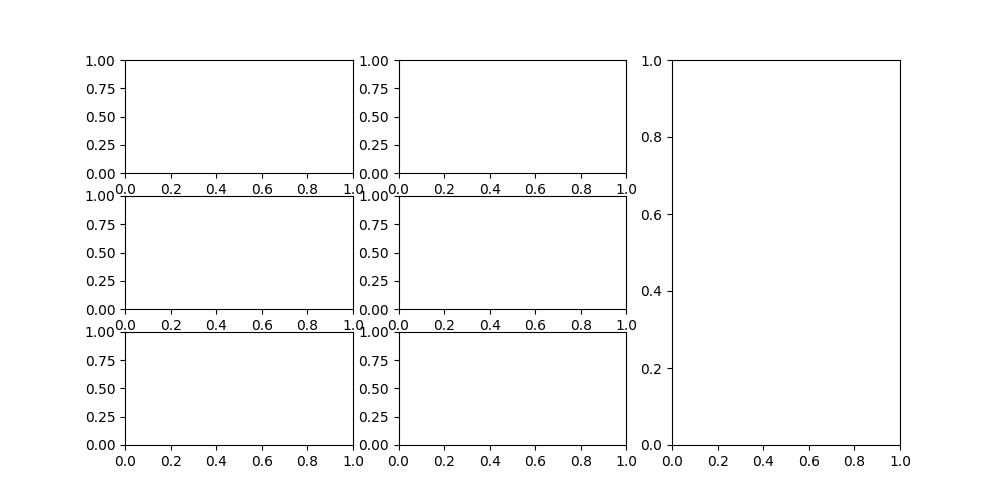

In [15]:
# fig = plt.figure(figsize=(10, 5))
# fig.add_subplot(331)
# fig.add_subplot(332)
# fig.add_subplot(334)
# fig.add_subplot(335)
# fig.add_subplot(337)
# fig.add_subplot(338)
# fig.add_subplot(133)



# plt.show()

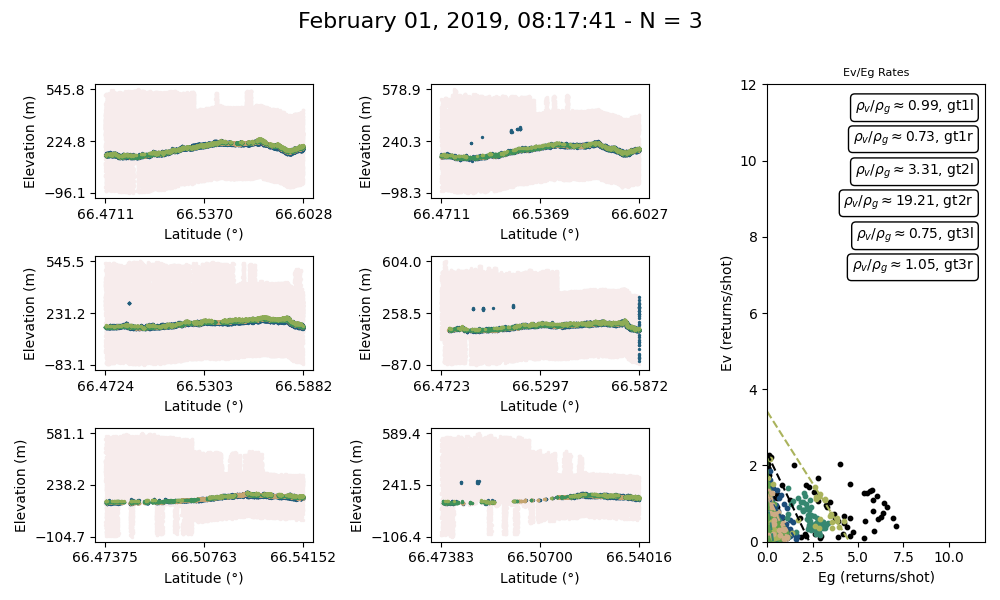

In [2]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

def pvpg_parallel(atl03path, atl08path,f_scale = .1, loss = 'arctan', bounds = ([-100, 0], [-1/100, 16]), file_index = None, res = residuals, model = model, rt = None, zeros=False):
    """
    Parallel regression of all tracks on a given overpass.

    atl03path - Path/to/ATL03/file
    atl08path - Path/to/matching/ATL08/file
    f_scale - Parameter in least_squares() function when loss is nonlinear, indiciating the value of the soft margin between inlier and outlier residuals.
    loss - string for loss parameter in least_squares().
    bounds - bounds for slope of line and y-intercept in shape ([--,--],[--,--]), allowing us to restrict the regression to realistic values.
    file_index - Index of file if cycling through an array of filenames, displayed in figure titles for a given file. Allows us to easily pick out strange cases for investigation.
    res - Default holds the ODR residuals function to be used in least_squares(). Can hold adjusted residual functions as well.
    x_guess - Initial guess for regression slope for each regression, default set to -1.
    y_guess - Function used to produce initial guess for y_intercept, default set as highest Ev return in track.
    rt - this will trigger RANSAC regression, and is also equal to the residual threshold of the regression.
    """
    
    i = 0
    
    tracks = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
    A = h5py.File(atl03path, 'r')
        
    for gt in tracks:
        try:
            if 0 in A[gt]['geolocation']['ph_index_beg']:
                print('File ' + str(file_index) + ' has been skipped.')
                A.close()
                return
                # This block will be executed if 0 is found in the list
        except (KeyError, FileNotFoundError):
            # Handle the exception (e.g., print a message or log the error)
            continue
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(334)
    ax4 = fig.add_subplot(335)
    ax5 = fig.add_subplot(337)
    ax6 = fig.add_subplot(338)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    ax7 = fig.add_subplot(133)
    
    # Extracting date and time from the filename
    title_date = parse_filename_datetime(atl03path)

    # Set the figure title
    if file_index != None:
        fig.suptitle(title_date + ' - N = ' + str(file_index), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)

    for i, gt in enumerate(tracks):
        
        try:
            atl03 = ATL03(atl03path, atl08path, gt)
        except (KeyError, ValueError, OSError) as e:
            i += 1
            continue
        if zeros == False:
            atl08 = ATL08(atl08path, gt)
        else:
            atl08 = ATL08_with_zeros(atl08path, gt)

        atl03.plot_small(axes[i])

        X = atl08.df.Eg
        Y = atl08.df.Ev
        
        init = [-1, np.max(Y)]
        
        if rt != None:
            a_guess, b_guess, ransac_model, inlier_mask = run_ransac(X, Y, loss=loss, rt=rt)
            ax7.scatter(X,Y, s=10, label=f"{gt} - RANSAC", color=cmap(i/len(tracks)))
        
        else:
            a_guess, b_guess = odr(X, Y, res = res, init=init, loss=loss, bounds=bounds, f_scale=f_scale)
            ax7.scatter(X,Y, s=10, label=f"{gt} - ODR", color=cmap(i/len(tracks)))
        ax7.plot(np.array([0,12]), model([a_guess, b_guess], np.array([0,12])), label='Orthogonal Distance Regression', color=cmap(i/len(tracks)), linestyle='--', zorder=2)
        ax7.annotate(r'$\rho_v/\rho_g \approx {:.2f}$, {}'.format(-a_guess, gt),
                       xy=(.95,.97-.07*i),
                       xycoords='axes fraction',
                       ha='right',
                       va='top',
                       bbox=dict(boxstyle="round,pad=0.3",
                                 edgecolor="black",
                                 facecolor="white"))
        i += 1
        
    ax7.set_title(f"Ev/Eg Rates", fontsize=8)
    ax7.set_xlabel('Eg (returns/shot)')
    ax7.set_ylabel('Ev (returns/shot)')
    ax7.set_xlim(0,12)
    ax7.set_ylim(0,12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()
    return

for j in range(3,4):
    pvpg_parallel(all_ATL03[j],all_ATL08[j],
                           f_scale=.1,
                           loss = 'arctan',
                           file_index=j)

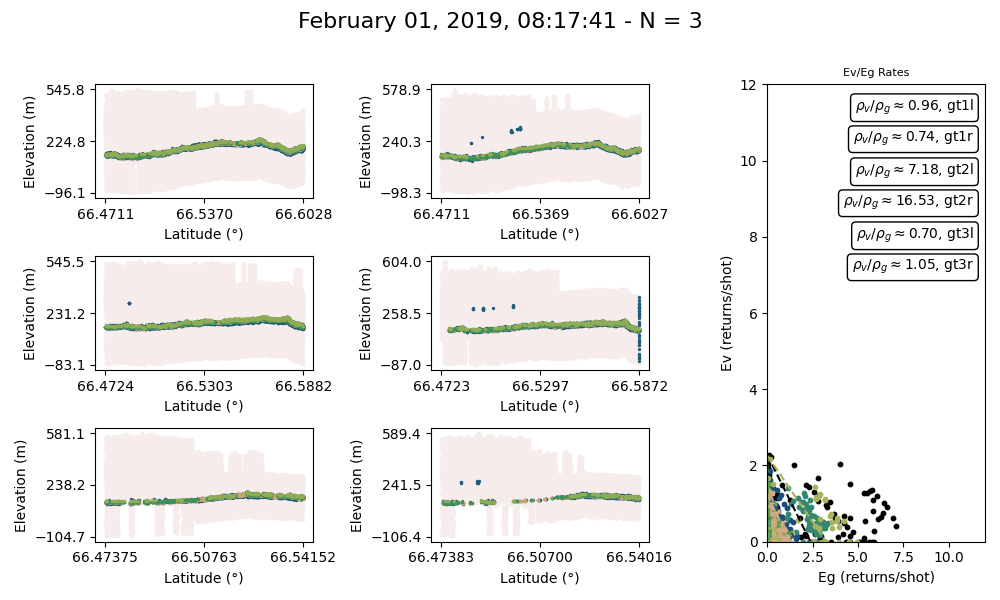

In [3]:
for j in range(3,4):
    pvpg_parallel(all_ATL03[j],all_ATL08[j],
                           f_scale=.1,
                           loss = 'arctan',
                           file_index=j,
                           zeros = True)

In [12]:
from concurrent.futures import ProcessPoolExecutor
from functools import partial

# ... (previous imports)

def process_track(atl03path, atl08path, gt, f_scale, loss, bounds, file_index, res, model, rt, zeros):
    try:
        pvpg_parallel(atl03path, atl08path, gt, f_scale, loss, bounds, file_index, res, model, rt, zeros)
    except Exception as e:
        print(f"Error processing track {gt}: {e}")

def main():
    dirpath = '../data/rovaniemi_w/'
    all_ATL03, all_ATL08 = track_pairs(dirpath)
    N = len(all_ATL03)

    f_scale = 0.1
    loss = 'arctan'
    bounds = ([-100, 0], [-1/100, 16])

    with ProcessPoolExecutor() as executor:
        futures = []
        for file_index, (atl03path, atl08path) in enumerate(zip(all_ATL03, all_ATL08)):
            for gt in ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']:
                futures.append(executor.submit(process_track, atl03path, atl08path, gt, f_scale, loss, bounds, file_index, residuals, model, None, False))

        # Wait for all tasks to complete
        for future in futures:
            future.result()

if __name__ == "__main__":
    main()


Error processing track gt1r: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were given
Error processing track gt1l: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were given
Error processing track gt2l: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were givenError processing track gt2r: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were givenError processing track gt3l: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were givenError processing track gt2l: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were given
Error processing track gt3r: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were givenError processing track gt2r: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were given
Error processing track gt3l: pvpg_parallel() takes from 2 to 10 positional arguments but 11 were givenError processing track gt3r: pvpg_parallel() takes from 2 to 10 positional arg

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Generate example data
np.random.seed(42)
n_samples = 50
n_datasets = 3

data = pd.DataFrame()

for i in range(n_datasets):
    x = np.random.rand(n_samples)
    y = 2 * x + 1 + np.random.randn(n_samples)
    data = pd.concat([data, pd.DataFrame({'x': x, 'y': y, 'dataset': f'dataset_{i+1}'})])

# Add a constant term to the independent variable
data['const'] = 1

# Create a design matrix with a dummy variable for each dataset
design_matrix = pd.get_dummies(data['dataset'], drop_first=True)

data

# Concatenate the design matrix with the original data
# X = pd.concat([data[['const', 'x']], design_matrix], axis=1)

# Perform pooled regression with shared slope
# y = data['y']

# model = sm.OLS(y, X)
# results = model.fit()

# # Display regression results
# print(results.summary())

,x,y,dataset,const
0,0.374540,2.487547,dataset_1,1
1,0.950714,3.072797,dataset_1,1
2,0.731994,2.348340,dataset_1,1
3,0.598658,1.896213,dataset_1,1
4,0.156019,-0.166485,dataset_1,1
...,...,...,...,...
45,0.649964,2.240403,dataset_3,1
46,0.701967,-0.837334,dataset_3,1
47,0.795793,1.567198,dataset_3,1
48,0.890005,2.527443,dataset_3,1
